In [225]:
#new cluster sim
from cluster_g import *
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


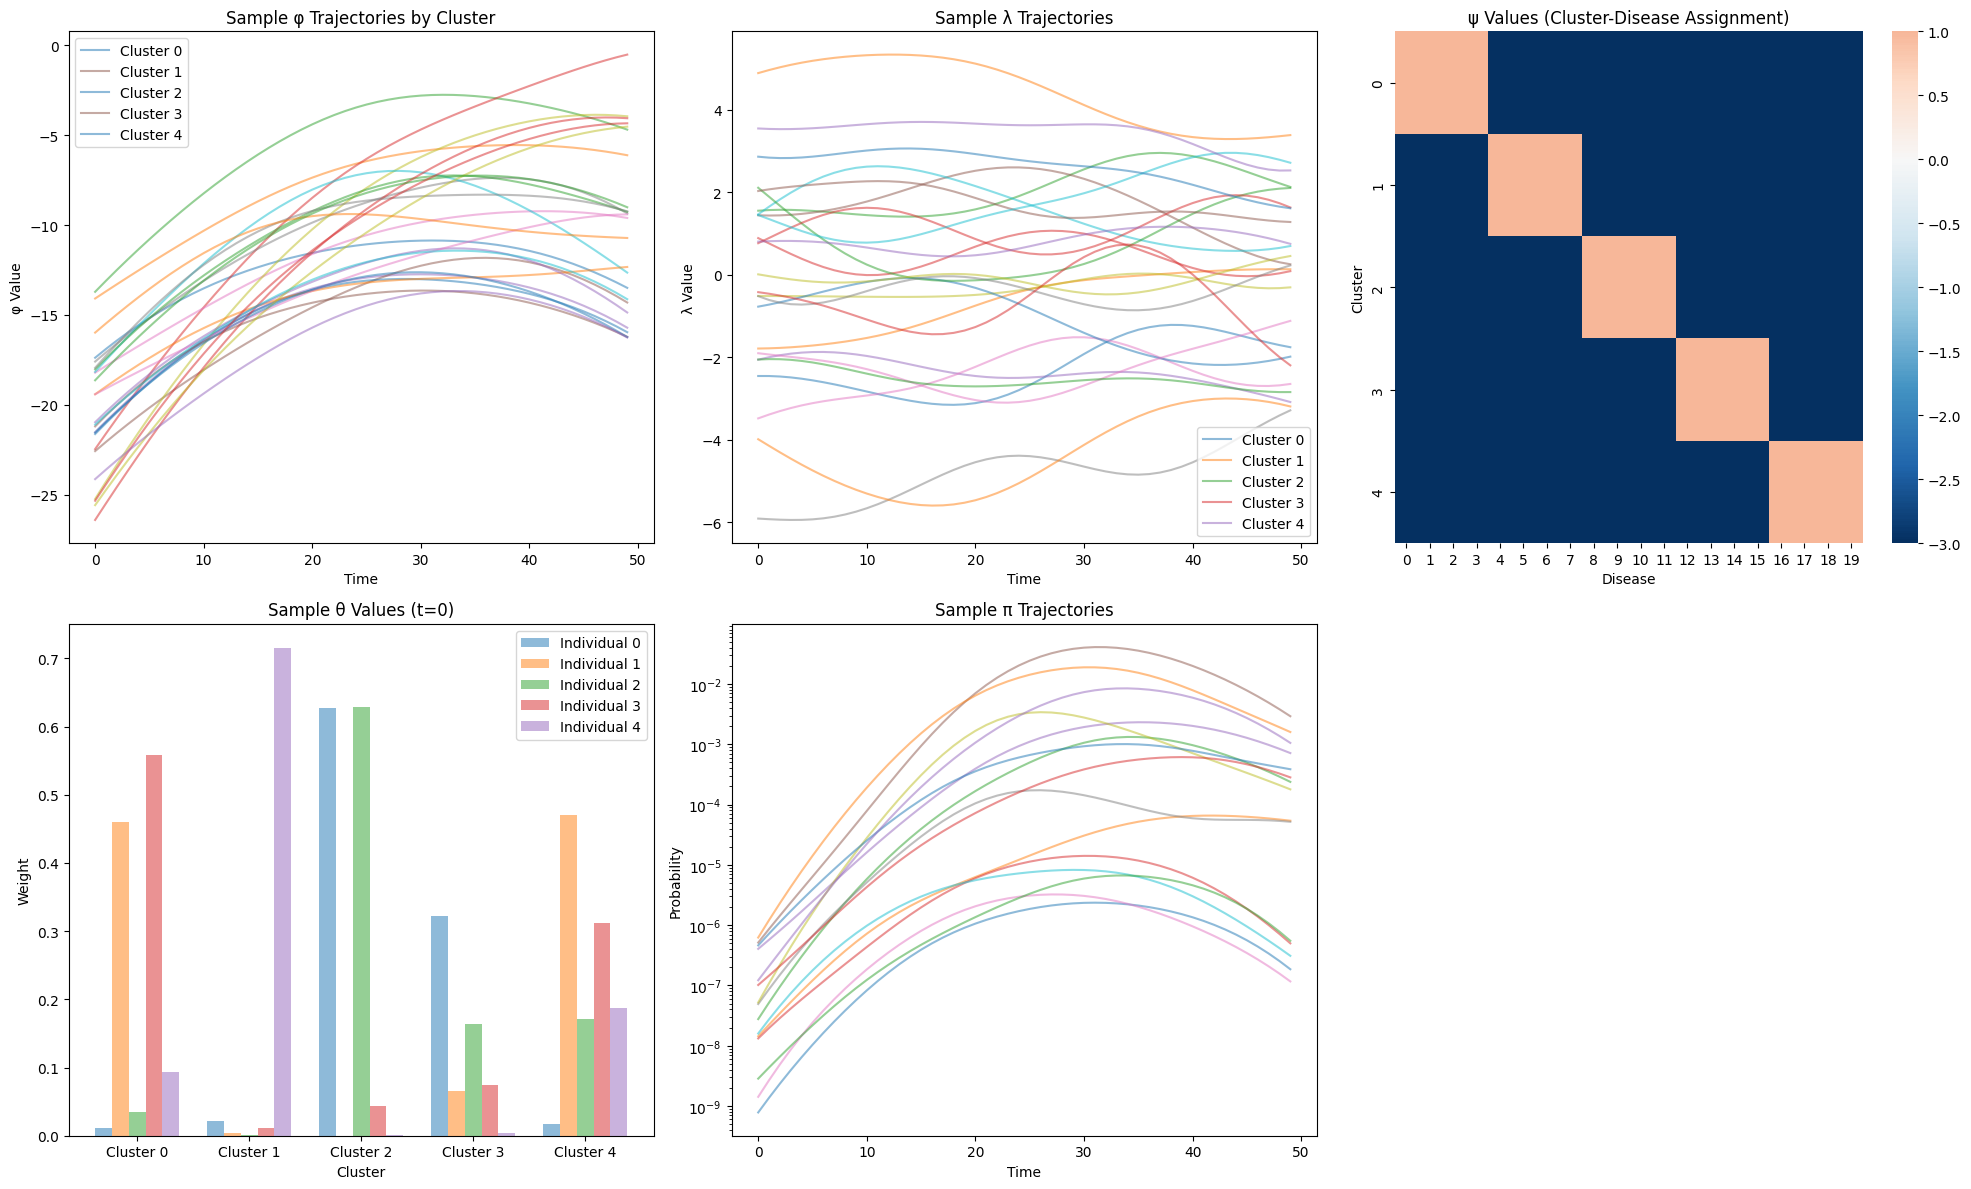

In [226]:
# Generate and plot
np.random.seed(42)
data = generate_clustered_survival_data(N=10000, D=20, T=50, K=5, P=5)
plot_synthetic_components(data)

In [227]:
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
Y_avg = torch.mean(Y_tensor, dim=2)
Y_corr = torch.corrcoef(Y_avg.T)
Y_avg


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0200, 0.0000, 0.0000]])

In [228]:

K=5
similarity = (Y_corr + 1) / 2
spectral = SpectralClustering(
            n_clusters=K,  # One less for background state
            assign_labels='kmeans',
            affinity='precomputed',
            n_init=10,
            random_state=42
        ).fit(similarity.numpy())
        
clusters = spectral.labels_

In [235]:
print("Number of events per disease:")
print(data['Y'].sum(axis=(0,2)))  # Sum over individuals and time
print(data['Y'].mean(axis=(0,2)))  # Sum over individuals and time

print("\nNumber of events per time point:")
print(data['Y'].sum(axis=(0,1)))  # Sum over individuals and diseases

Number of events per disease:
[1.000e+00 1.300e+02 1.355e+03 3.637e+03 2.800e+01 7.646e+03 4.710e+02
 1.000e+04 3.637e+03 6.663e+03 8.242e+03 2.370e+02 9.986e+03 1.247e+03
 8.220e+02 9.059e+03 9.957e+03 9.801e+03 6.000e+00 2.830e+02]
[2.0000e-06 2.6000e-04 2.7100e-03 7.2740e-03 5.6000e-05 1.5292e-02
 9.4200e-04 2.0000e-02 7.2740e-03 1.3326e-02 1.6484e-02 4.7400e-04
 1.9972e-02 2.4940e-03 1.6440e-03 1.8118e-02 1.9914e-02 1.9602e-02
 1.2000e-05 5.6600e-04]

Number of events per time point:
[  12.   22.   27.   57.  103.  145.  236.  303.  413.  486.  540.  611.
  623.  695.  701.  736.  821.  922. 1043. 1090. 1178. 1237. 1245. 1252.
 1235. 1282. 1378. 1541. 1748. 2033. 2208. 2551. 2865. 2939. 3117. 3191.
 3224. 3270. 3361. 3302. 3448. 3398. 3492. 3229. 3095. 3024. 2774. 2574.
 2284. 2147.]


In [238]:
# First generate synthetic data
np.random.seed(42)

# Convert data to tensors for the model
Y_tensor = torch.tensor(data['Y'], dtype=torch.float32)
G_tensor = torch.tensor(data['G'], dtype=torch.float32)
E_tensor = torch.tensor(data['event_times'], dtype=torch.float32)
true_psi = torch.tensor(data['psi'], dtype=torch.float32)


In [239]:
true_psi

tensor([[ 1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,
          1.,  1., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3.,  1.,  1.,  1.,  1.]])

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 45214952.00
Phi kernel condition number: 104912536.00

Cluster Sizes:
Cluster 0: 3 diseases
Cluster 1: 8 diseases
Cluster 2: 4 diseases
Cluster 3: 3 diseases
Cluster 4: 2 diseases
Initialization complete!

Using true psi from simulation
Initialization complete!


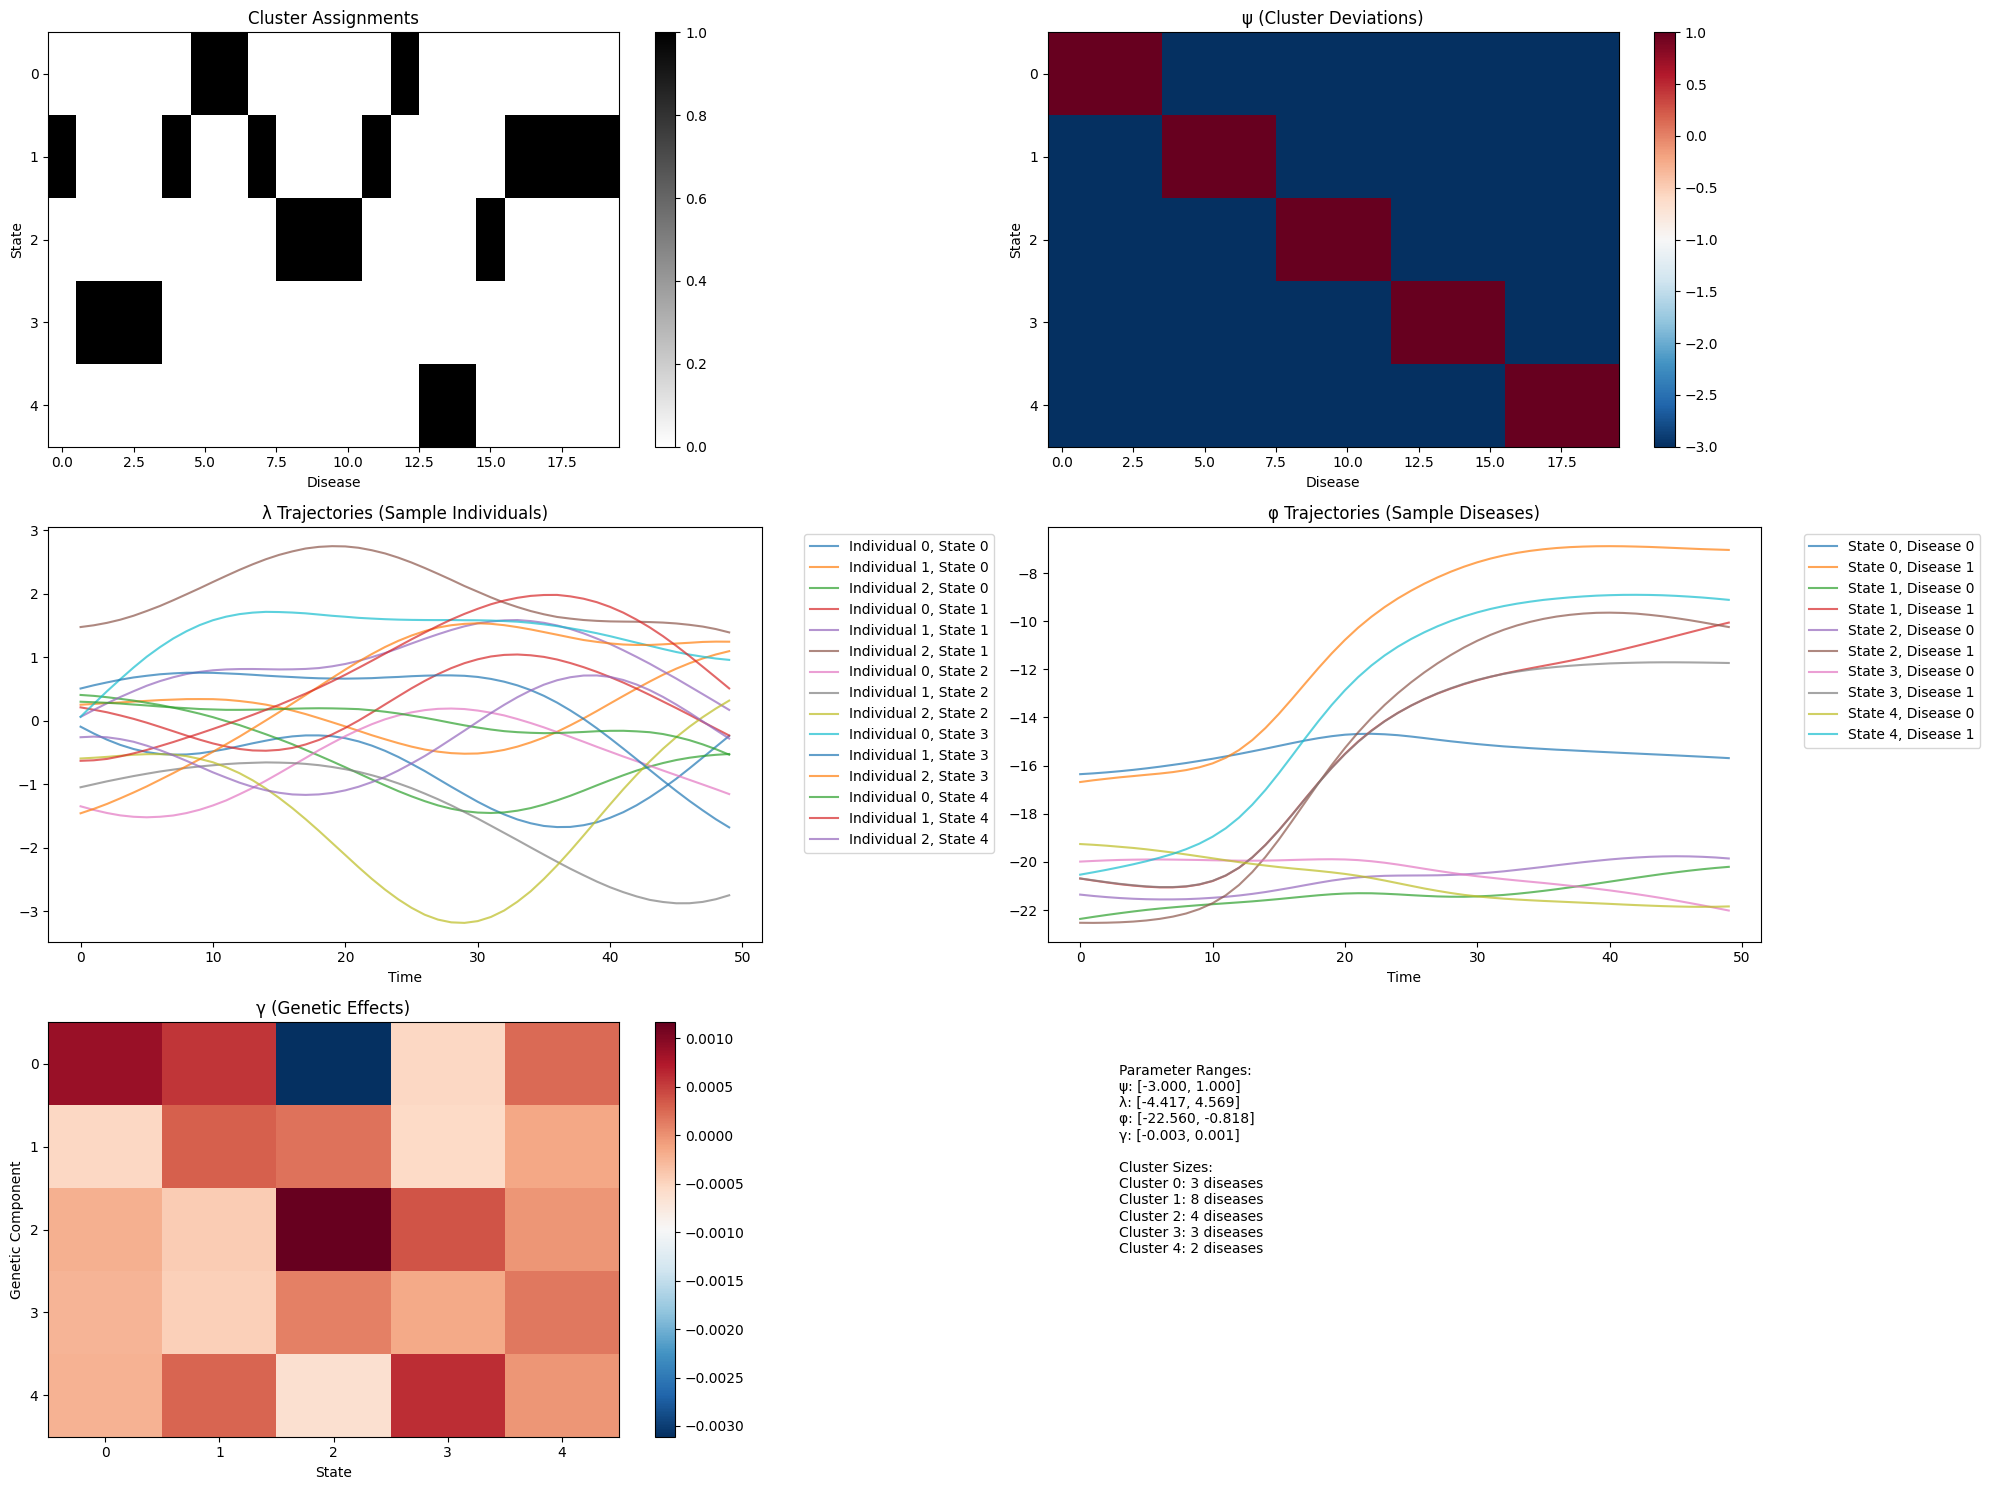

In [243]:

# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals

# Initialize model with synthetic data
model = AladynSurvivalFixedKernelsAvgLoss_clust(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,              # Added Y_tensor
    prevalence_t=prevalence_t
)

# Initialize with true psi
model.initialize_params(true_psi=true_psi)


model.visualize_initialization()


In [244]:

K=5
# Store initial psi values
initial_psi = model.psi.detach().clone()

# Fit the model
history = model.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)


Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 287.2408
Psi gradient stats:
Mean: -3.6674e-03
Std:  7.7569e-02
Max:  2.0641e-01
Min:  -2.1779e-01
Average psi change: 9.9921e-05
Epoch 0, Loss: 287.2408, Gradients - Lambda: 5.130e-01, Phi: 1.809e+02, Gamma: 4.366e-02, Psi: 2.178e-01

Epoch 1
Loss: 223.1519
Psi gradient stats:
Mean: -4.0849e-03
Std:  7.7390e-02
Max:  2.0538e-01
Min:  -2.1577e-01
Average psi change: 9.9283e-05
Epoch 1, Loss: 223.1519, Gradients - Lambda: 4.591e-01, Phi: 1.683e+02, Gamma: 4.223e-02, Psi: 2.158e-01

Estimated total training time: 250.1 minutes

Epoch 2
Loss: 177.3818
Psi gradient stats:
Mean: -4.5246e-03
Std:  7.7200e-02
Max:  2.0367e-01
Min:  -2.1367e-01
Average psi change: 9.8547e-05
Epoch 2, Loss: 177.3818, Gradients - Lambda: 4.157e-01, Phi: 1.538e+02, Gamma: 4.071e-02, Psi: 2.137e-01

Epoch 3
Loss: 146.1652
Psi gradient stats:
Mean: -4.9606e-03
Std:  7.6987e-02
Max:  2.0110e-01
Min:  -2.1190e-01
Average psi change: 9.8823e-05
Epoch 3, Loss: 146.1652, Gradients - Lambda: 3.729e-01, Phi

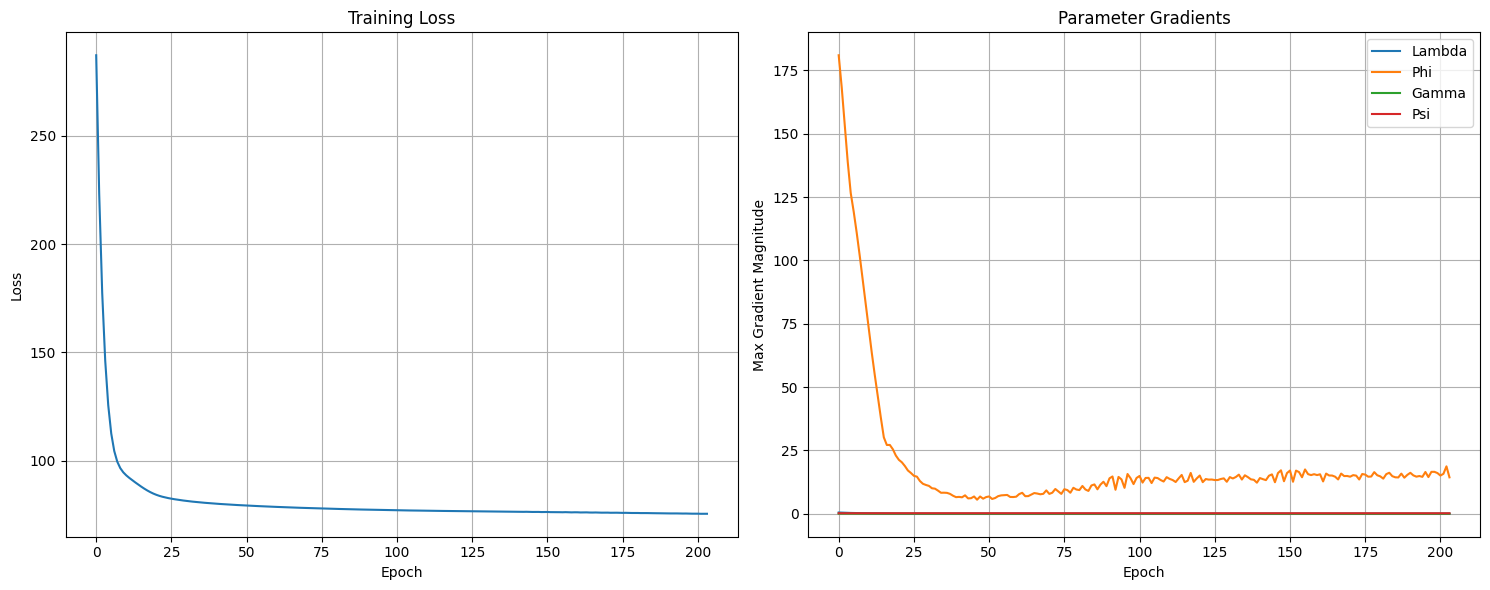

In [245]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history['max_grad_lambda'], label='Lambda')
ax2.plot(history['max_grad_phi'], label='Phi')
ax2.plot(history['max_grad_gamma'], label='Gamma')
ax2.plot(history['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [286]:
initial_psi


tensor([[ 1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3., -3., -3., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,  1.,  1., -3., -3.,
         -3., -3., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,  1.,  1.,
          1.,  1., -3., -3., -3., -3.],
        [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
         -3., -3.,  1.,  1.,  1.,  1.]])

In [247]:
model.psi

Parameter containing:
tensor([[ 1.0406,  0.9608,  0.9595,  0.9605, -2.9613, -3.0083, -2.9598, -2.9622,
         -2.9598, -2.9596, -3.0337, -2.9622, -3.0370, -3.0344, -2.9635, -3.0433,
         -2.9614, -2.9582, -2.9593, -3.0270],
        [-3.0394, -2.9629, -3.0348, -2.9607,  1.0368,  0.9624,  0.9591,  1.0374,
         -2.9639, -2.9584, -2.9593, -2.9575, -3.0382, -3.0350, -2.9568, -2.9633,
         -2.9608, -3.0398, -3.0395, -3.0365],
        [-2.9794, -3.0411, -3.0286, -3.0141, -3.0259, -2.9592, -2.9591, -3.0373,
          1.0396,  1.0397,  1.0400,  1.0381, -3.0430, -3.0334, -3.0395, -3.0412,
         -3.0426, -3.0307, -3.0395, -2.9590],
        [-3.0395, -3.0393, -3.0418, -2.9635, -3.0389, -3.0425, -2.9619, -3.0359,
         -3.0298, -3.0408, -2.9779, -2.9586,  1.0390,  1.0416,  1.0404,  1.0288,
         -3.0374, -2.9593, -3.0043, -3.0398],
        [-2.9699, -2.9592, -3.0268, -3.0436, -3.0117, -2.9630, -2.9579, -3.0397,
         -3.0425, -2.9595, -3.0415, -2.9596, -3.0397, -2.9626, -2

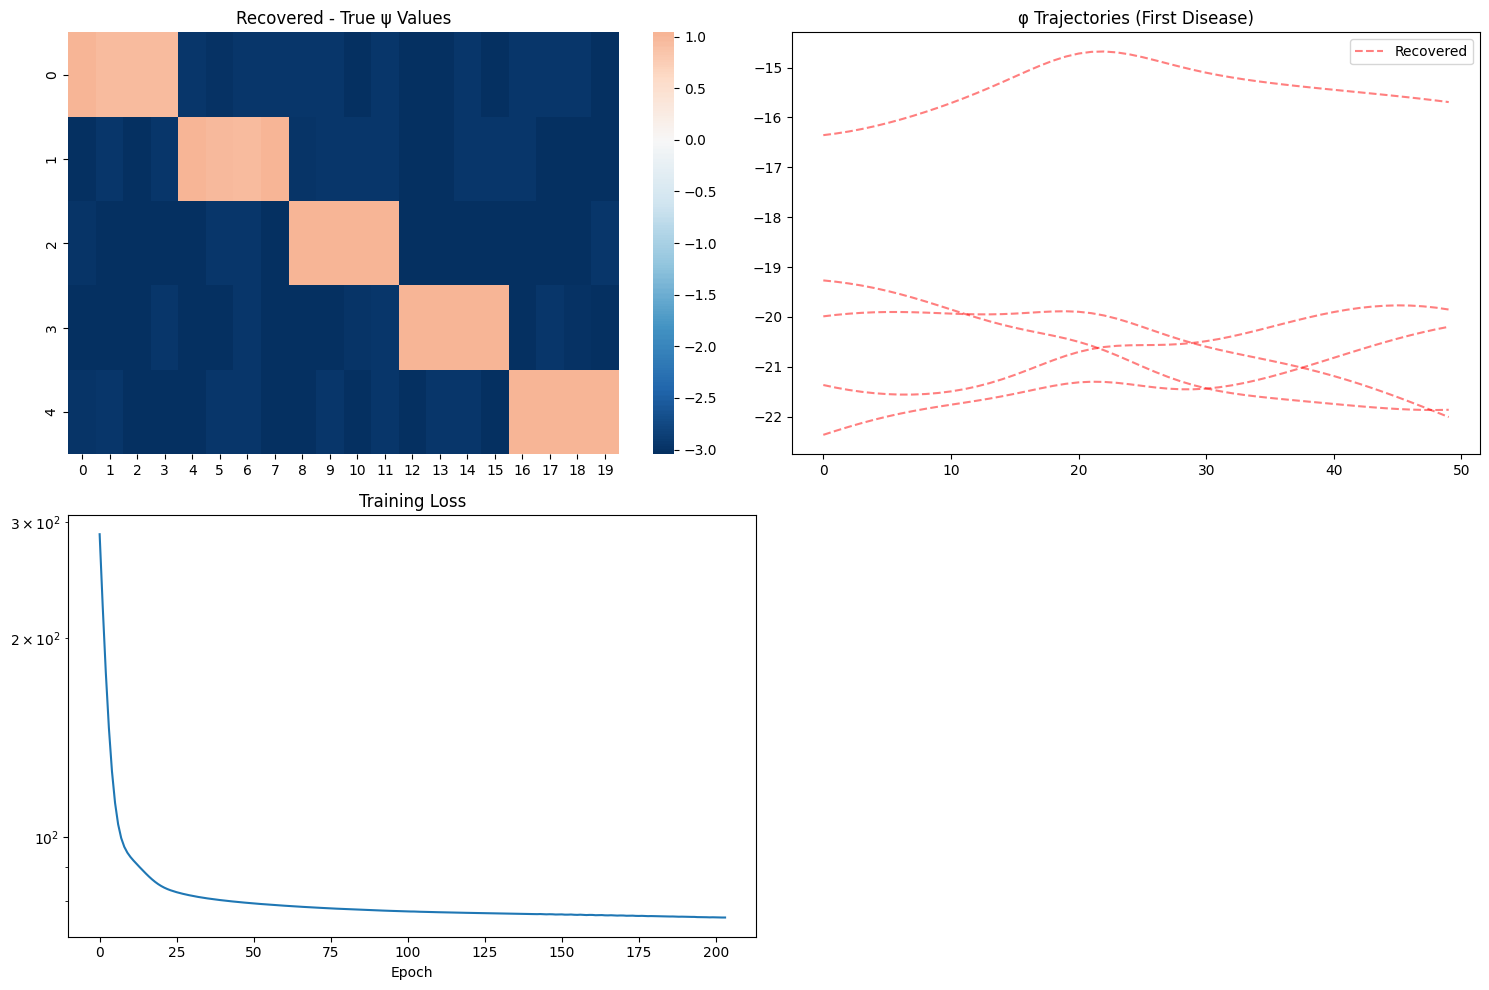


Overall psi changes:
0.03666137531399727


In [248]:

# Compare recovered vs true parameters
def compare_parameters(model, true_data):
    plt.figure(figsize=(15, 10))
    
    # 1. Compare psi values
    plt.subplot(221)
    sns.heatmap(model.psi.detach().numpy(), 
                cmap='RdBu_r', center=0)
    plt.title('Recovered - True ψ Values')
    
    # 2. Compare phi trajectories
    plt.subplot(222)
    recovered_phi = model.phi.detach().numpy()
    for k in range(K):
        #plt.plot(true_data['phi'][k,0,:], 'b-', alpha=0.5, label='True' if k==0 else '')
        plt.plot(recovered_phi[k,0,:], 'r--', alpha=0.5, label='Recovered' if k==0 else '')
    plt.title('φ Trajectories (First Disease)')
    plt.legend()
    
    # 3. Training history
    plt.subplot(223)
    plt.plot(history['loss'])
    plt.yscale('log')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()

# Compare results
compare_parameters(model, data)

print("\nOverall psi changes:")
print(torch.abs(model.psi - initial_psi).mean().item())

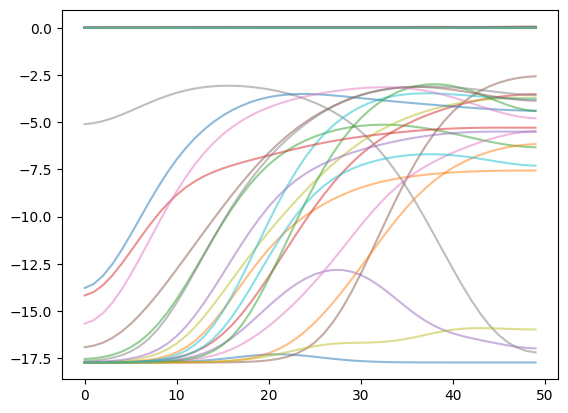

In [249]:
epsilon=1e-8
logit_prev_t = torch.log(
            (model.prevalence_t + epsilon) / (1 - model.prevalence_t + epsilon)
        )  # D 

for d in range(data['Y'].shape[1]):
    plt.plot(logit_prev_t[d,:], alpha=0.5, label=f'Disease {d}' if d < 5 else '')

for d in range(data['Y'].shape[1]):
    plt.plot(model.prevalence_t[d,:], alpha=0.5, label=f'Disease {d}' if d < 5 else '')


In [ ]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = data['Y'].mean(axis=0)  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[:, d].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

In [250]:
print("Number of events per disease:")
print(data['Y'].sum(axis=(0,2)))  # Sum over individuals and time

print("\nNumber of events per time point:")
print(data['Y'].sum(axis=(0,1)))  # Sum over individuals and diseases

Number of events per disease:
[1.000e+00 1.300e+02 1.355e+03 3.637e+03 2.800e+01 7.646e+03 4.710e+02
 1.000e+04 3.637e+03 6.663e+03 8.242e+03 2.370e+02 9.986e+03 1.247e+03
 8.220e+02 9.059e+03 9.957e+03 9.801e+03 6.000e+00 2.830e+02]

Number of events per time point:
[  12.   22.   27.   57.  103.  145.  236.  303.  413.  486.  540.  611.
  623.  695.  701.  736.  821.  922. 1043. 1090. 1178. 1237. 1245. 1252.
 1235. 1282. 1378. 1541. 1748. 2033. 2208. 2551. 2865. 2939. 3117. 3191.
 3224. 3270. 3361. 3302. 3448. 3398. 3492. 3229. 3095. 3024. 2774. 2574.
 2284. 2147.]


In [252]:
model.logit_prev_t

tensor([[-17.7275, -17.7274, -17.7273, -17.7270, -17.7264, -17.7253, -17.7234,
         -17.7202, -17.7149, -17.7067, -17.6943, -17.6766, -17.6522, -17.6202,
         -17.5801, -17.5328, -17.4800, -17.4255, -17.3742, -17.3319, -17.3038,
         -17.2940, -17.3038, -17.3319, -17.3742, -17.4255, -17.4800, -17.5328,
         -17.5801, -17.6202, -17.6522, -17.6766, -17.6943, -17.7067, -17.7149,
         -17.7202, -17.7234, -17.7253, -17.7264, -17.7270, -17.7273, -17.7274,
         -17.7275, -17.7275, -17.7275, -17.7275, -17.7275, -17.7275, -17.7275,
         -17.7275],
        [-17.7245, -17.7228, -17.7189, -17.7117, -17.6988, -17.6773, -17.6425,
         -17.5876, -17.5033, -17.3768, -17.1924, -16.9321, -16.5805, -16.1304,
         -15.5873, -14.9697, -14.3047, -13.6223, -12.9506, -12.3129, -11.7252,
         -11.1961, -10.7267, -10.3133,  -9.9487,  -9.6254,  -9.3371,  -9.0791,
          -8.8492,  -8.6459,  -8.4684,  -8.3158,  -8.1860,  -8.0766,  -7.9846,
          -7.9069,  -7.8409,  -7

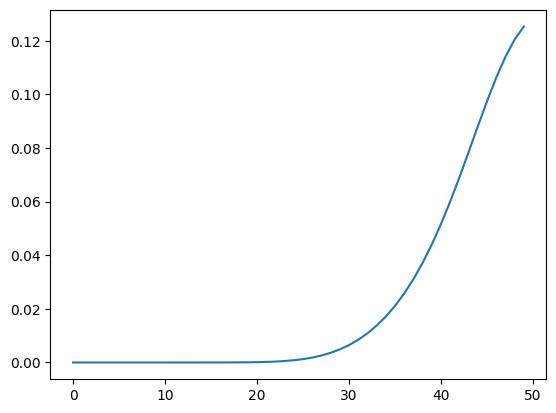

In [253]:
plt.plot(data['pi'][1,3,:])

In [254]:
print("Number of events per disease:")
print(data['Y'].sum(axis=(0,2)))  # Sum over individuals and time

print("\nNumber of events per time point:")
print(data['Y'].sum(axis=(0,1)))  # Sum over individuals and diseases

Number of events per disease:
[1.000e+00 1.300e+02 1.355e+03 3.637e+03 2.800e+01 7.646e+03 4.710e+02
 1.000e+04 3.637e+03 6.663e+03 8.242e+03 2.370e+02 9.986e+03 1.247e+03
 8.220e+02 9.059e+03 9.957e+03 9.801e+03 6.000e+00 2.830e+02]

Number of events per time point:
[  12.   22.   27.   57.  103.  145.  236.  303.  413.  486.  540.  611.
  623.  695.  701.  736.  821.  922. 1043. 1090. 1178. 1237. 1245. 1252.
 1235. 1282. 1378. 1541. 1748. 2033. 2208. 2551. 2865. 2939. 3117. 3191.
 3224. 3270. 3361. 3302. 3448. 3398. 3492. 3229. 3095. 3024. 2774. 2574.
 2284. 2147.]


In [280]:
with torch.no_grad():
    pi_pred, theta, phi = model_est.forward()
    pi_pred = pi_pred.cpu().numpy()

tensor(41.)

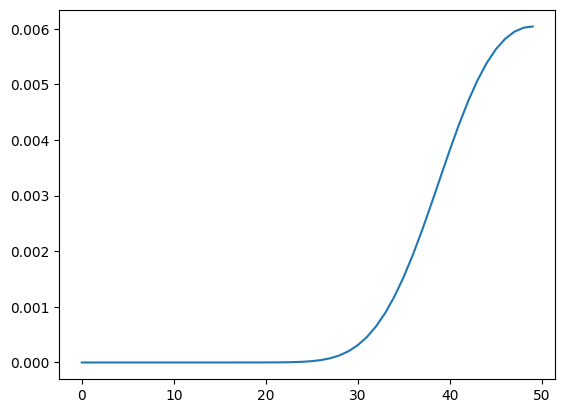

In [281]:
plt.plot(pi_pred[1,3,:])
E_tensor[1,3]

In [282]:
model_prev = torch.sigmoid(model.logit_prev_t)  
print(model_prev.shape)

data_prev = data['Y'].mean(axis=0) 
print(data_prev.shape)


torch.Size([20, 50])
(20, 50)


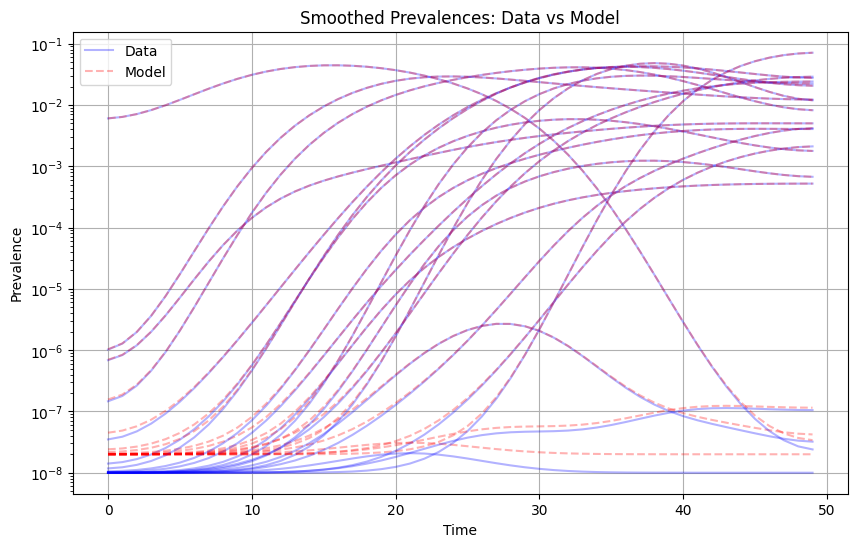

In [283]:
# For plotting smoothed prevalences
def plot_smoothed_prevalences(model, data):
    # Data smoothed prevalence
    data_prev = compute_smoothed_prevalence(data['Y'])  # Average across individuals
    
    # Model smoothed prevalence (using mu_d/logit_prev_t)
    model_prev = torch.sigmoid(model.logit_prev_t)  # Convert logits to probabilities
    
    plt.figure(figsize=(10, 6))
    
    # Plot for each disease
    for d in range(data_prev.shape[0]):
        plt.plot(data_prev[d], 'b-', alpha=0.3, label='Data' if d==0 else '')
        plt.plot(model_prev[d, :].detach().numpy(), 'r--', alpha=0.3, 
                label='Model' if d==0 else '')
    
    plt.xlabel('Time')
    plt.ylabel('Prevalence')
    plt.title('Smoothed Prevalences: Data vs Model')
    plt.legend()
    plt.yscale('log')  # Optional: use log scale if prevalences vary widely
    plt.grid(True)
    plt.show()

plot_smoothed_prevalences(model_est, data)

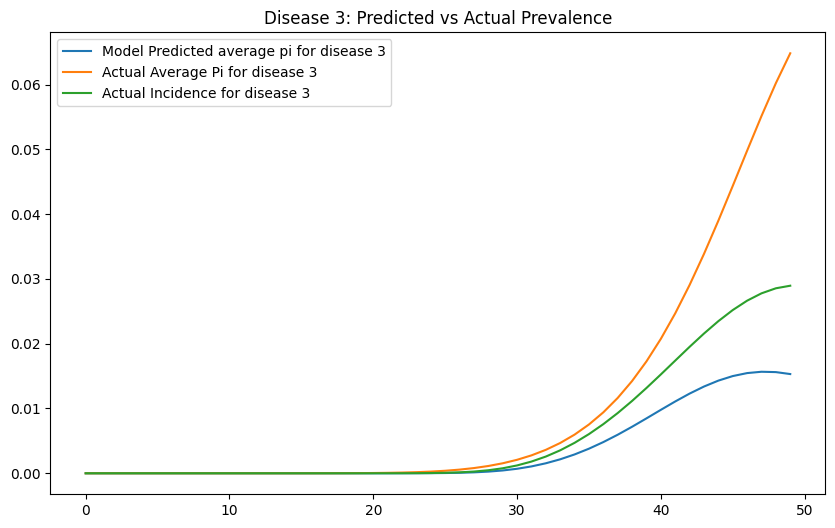

In [284]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[:, 3, :].mean(axis=0)  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted average pi for disease 3')
plt.plot(real_prev_pi, label='Actual Average Pi for disease 3 ')
plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

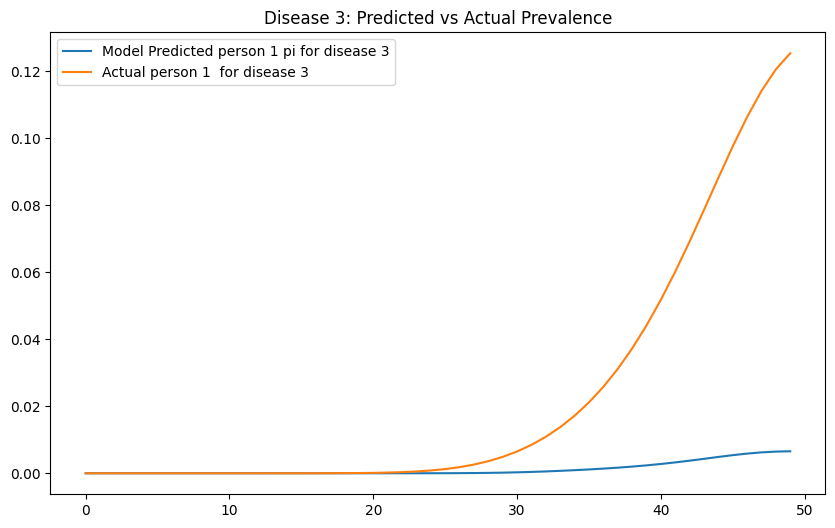

In [260]:
# Mean predicted probability for disease 3 over time
mean_pred_d3 = pi_pred[1, 3, :]  # Average across people

# Actual prevalence for disease 3 over time
real_prev_pi = data['pi'][1, 3, :]  # Average across people

#real_prev_d3 = data['Y'][:, 3, :].mean(axis=0)  # Average across people

#real_prev_d3 = model.prevalence_t[3,:]  # Average across people

# Plot comparison
plt.figure(figsize=(10,6))
plt.plot(mean_pred_d3, label='Model Predicted person 1 pi for disease 3')
plt.plot(real_prev_pi, label='Actual person 1  for disease 3 ')
#plt.plot(real_prev_d3, label='Actual Incidence for disease 3')
plt.title('Disease 3: Predicted vs Actual Prevalence')
plt.legend()
plt.show()

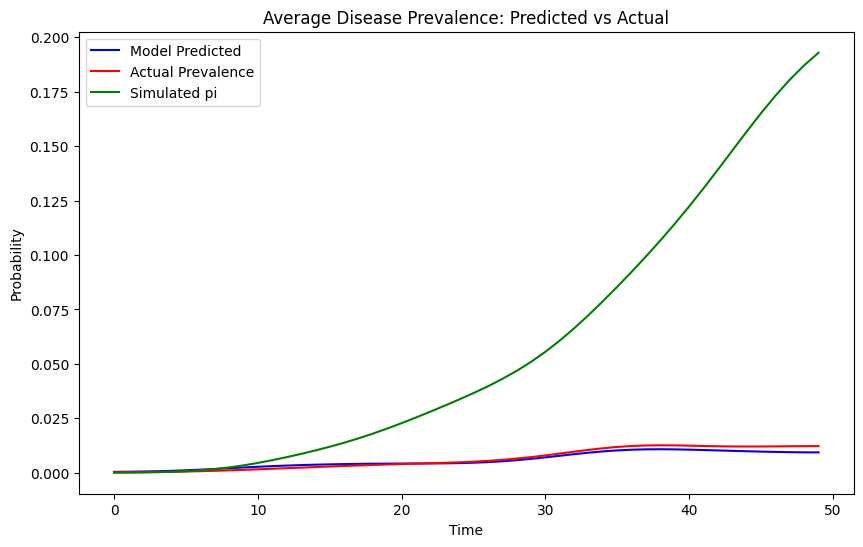

In [265]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

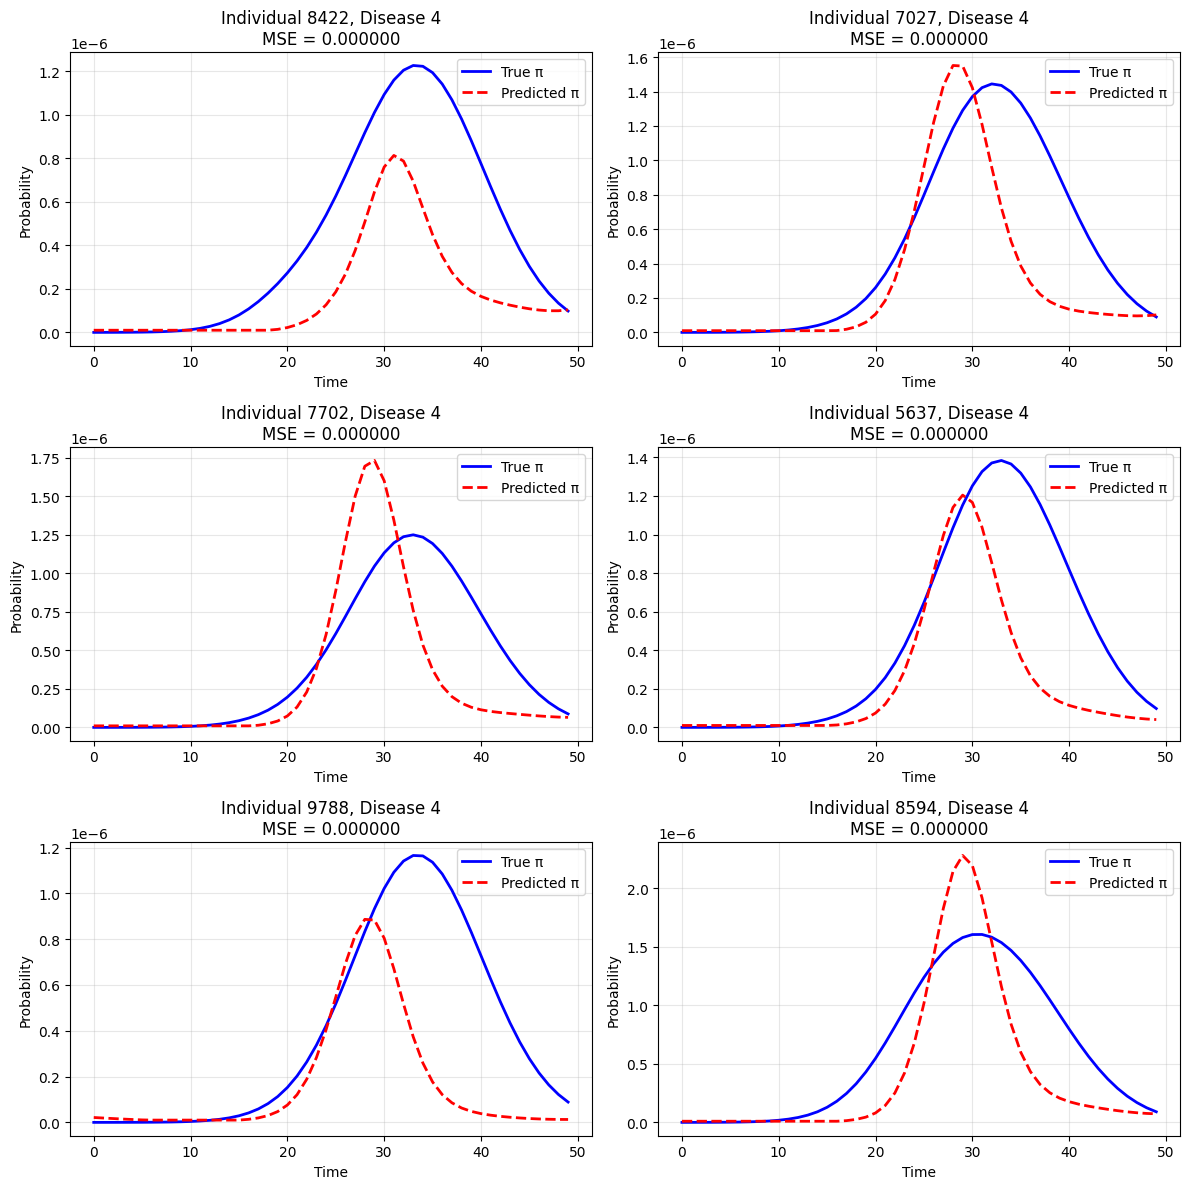

In [269]:
plot_best_matches(data['pi'], model.forward()[0],n_samples=6)


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 45214952.00
Phi kernel condition number: 104912536.00

Cluster Sizes:
Cluster 0: 3 diseases
Cluster 1: 8 diseases
Cluster 2: 4 diseases
Cluster 3: 3 diseases
Cluster 4: 2 diseases
Initialization complete!


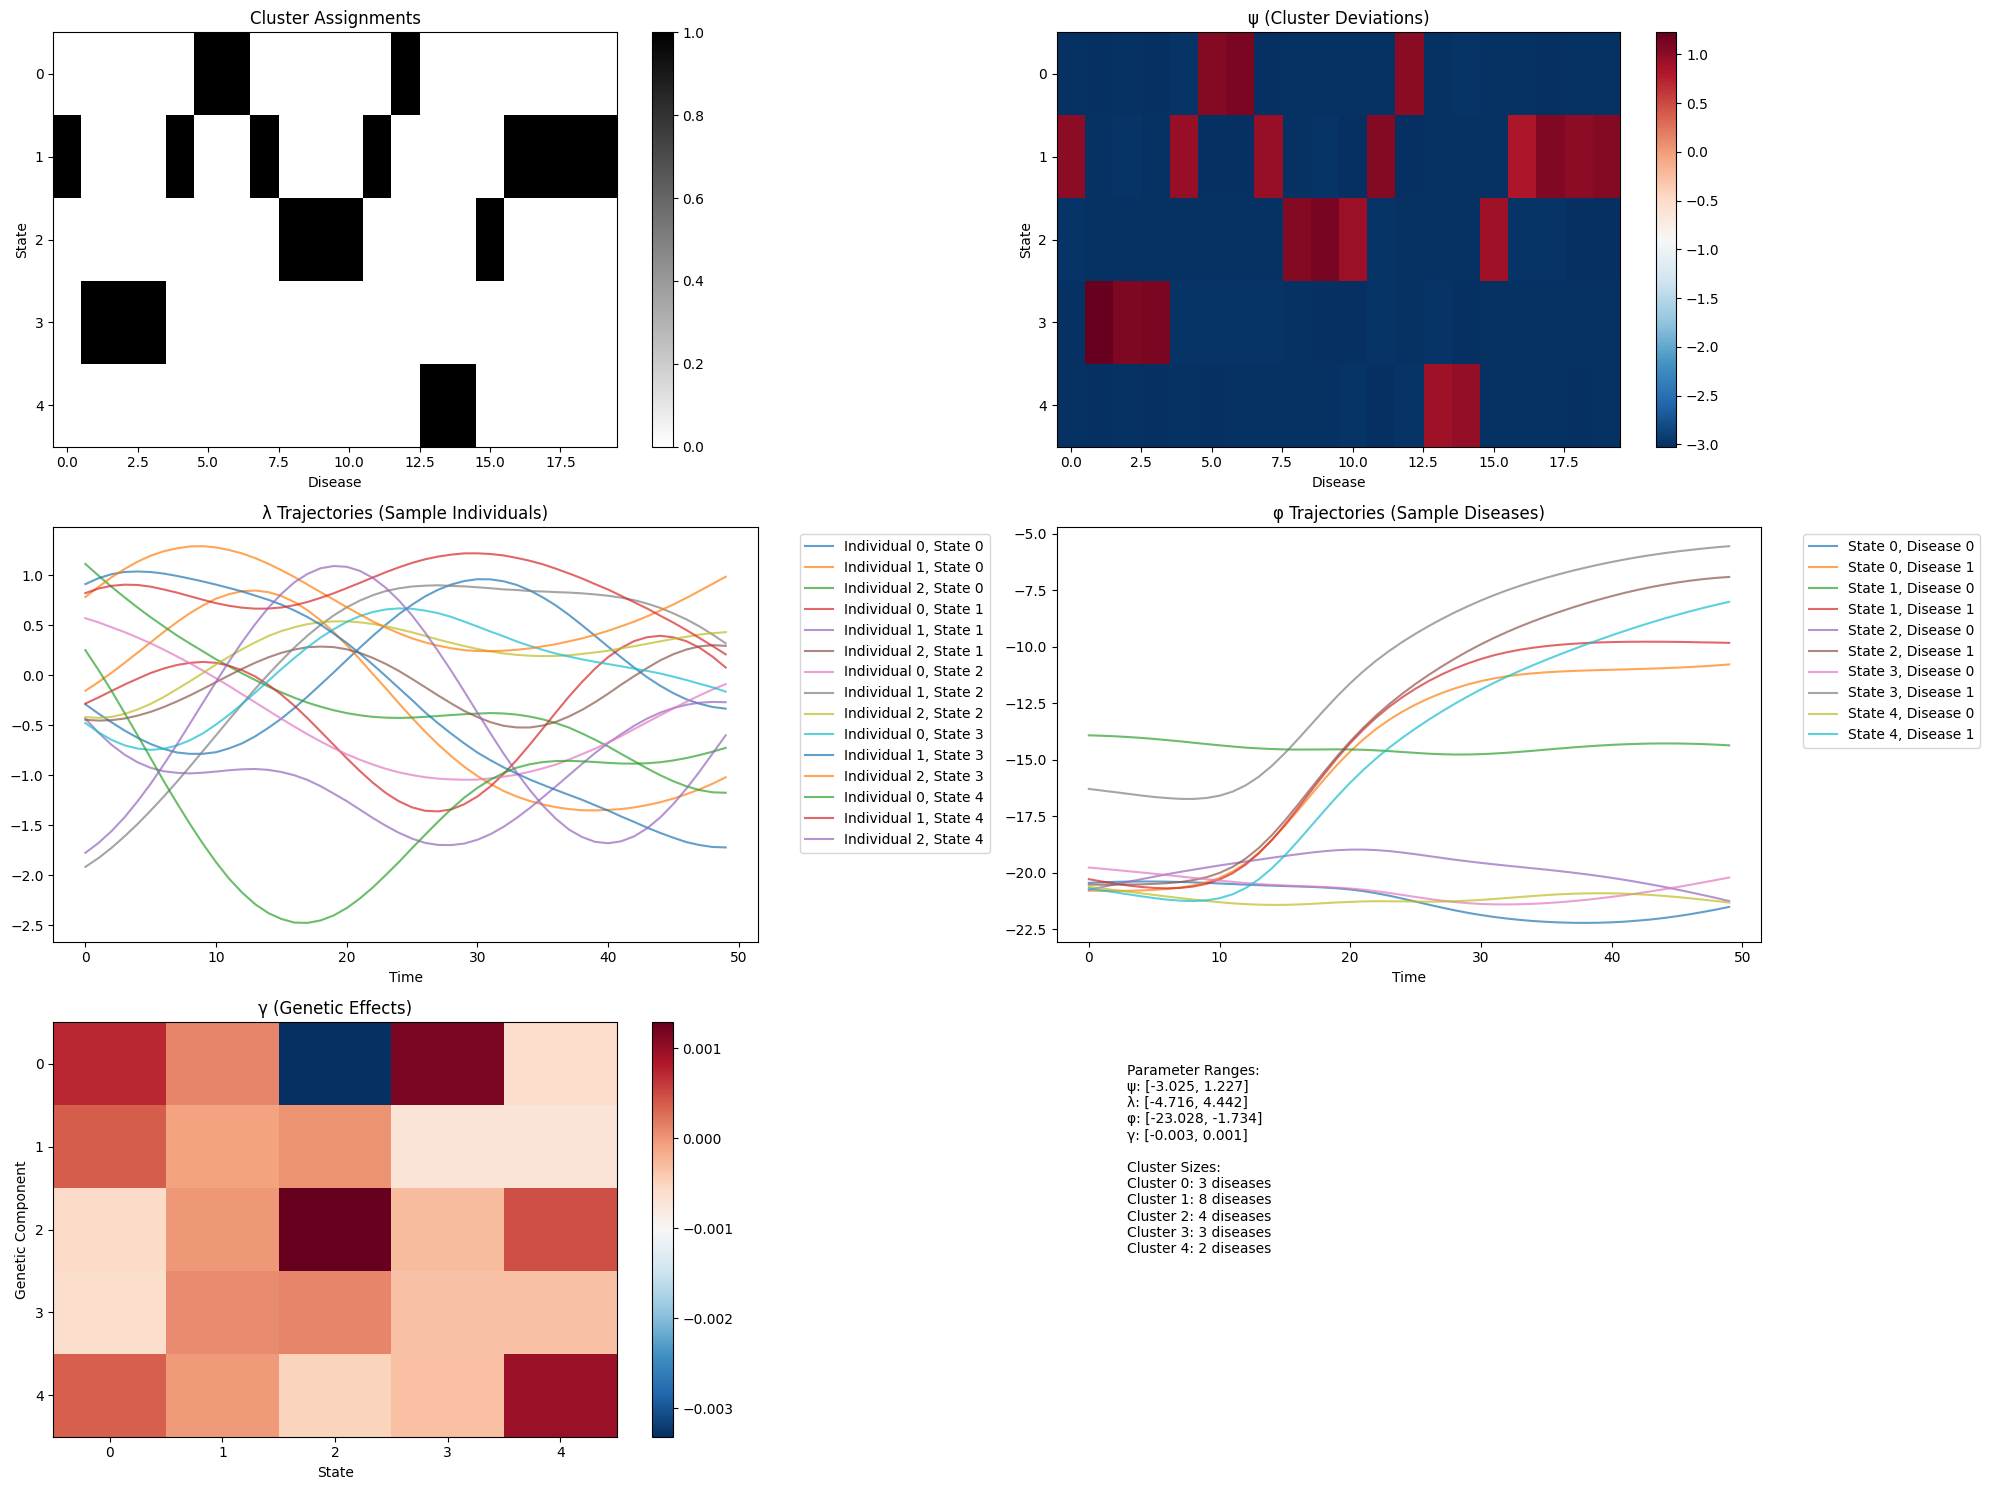

In [273]:

# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals

# Initialize model with synthetic data
model_est = AladynSurvivalFixedKernelsAvgLoss_clust(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,              # Added Y_tensor
    prevalence_t=prevalence_t
)

# Initialize with true psi


model_est.visualize_initialization()


In [275]:
history = model_est.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)


Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 290.4394
Psi gradient stats:
Mean: -5.9831e-03
Std:  8.9669e-02
Max:  1.8442e-01
Min:  -2.6258e-01
Average psi change: 9.9921e-05
Epoch 0, Loss: 290.4394, Gradients - Lambda: 5.107e-01, Phi: 1.936e+02, Gamma: 3.312e-02, Psi: 2.626e-01

Epoch 1
Loss: 226.5218
Psi gradient stats:
Mean: -5.8570e-03
Std:  8.9540e-02
Max:  1.8490e-01
Min:  -2.6246e-01
Average psi change: 9.9389e-05
Epoch 1, Loss: 226.5218, Gradients - Lambda: 4.510e-01, Phi: 1.787e+02, Gamma: 3.263e-02, Psi: 2.625e-01

Estimated total training time: 268.9 minutes

Epoch 2
Loss: 180.8995
Psi gradient stats:
Mean: -5.7330e-03
Std:  8.9427e-02
Max:  1.8411e-01
Min:  -2.6229e-01
Average psi change: 9.8624e-05
Epoch 2, Loss: 180.8995, Gradients - Lambda: 3.934e-01, Phi: 1.659e+02, Gamma: 3.200e-02, Psi: 2.623e-01

Epoch 3
Loss: 149.6907
Psi gradient stats:
Mean: -5.6219e-03
Std:  8.9291e-02
Max:  1.8313e-01
Min:  -2.6217e-01
Average psi change: 9.7601e-05
Epoch 3, Loss: 149.6907, Gradients - Lambda: 3.559e-01, Phi

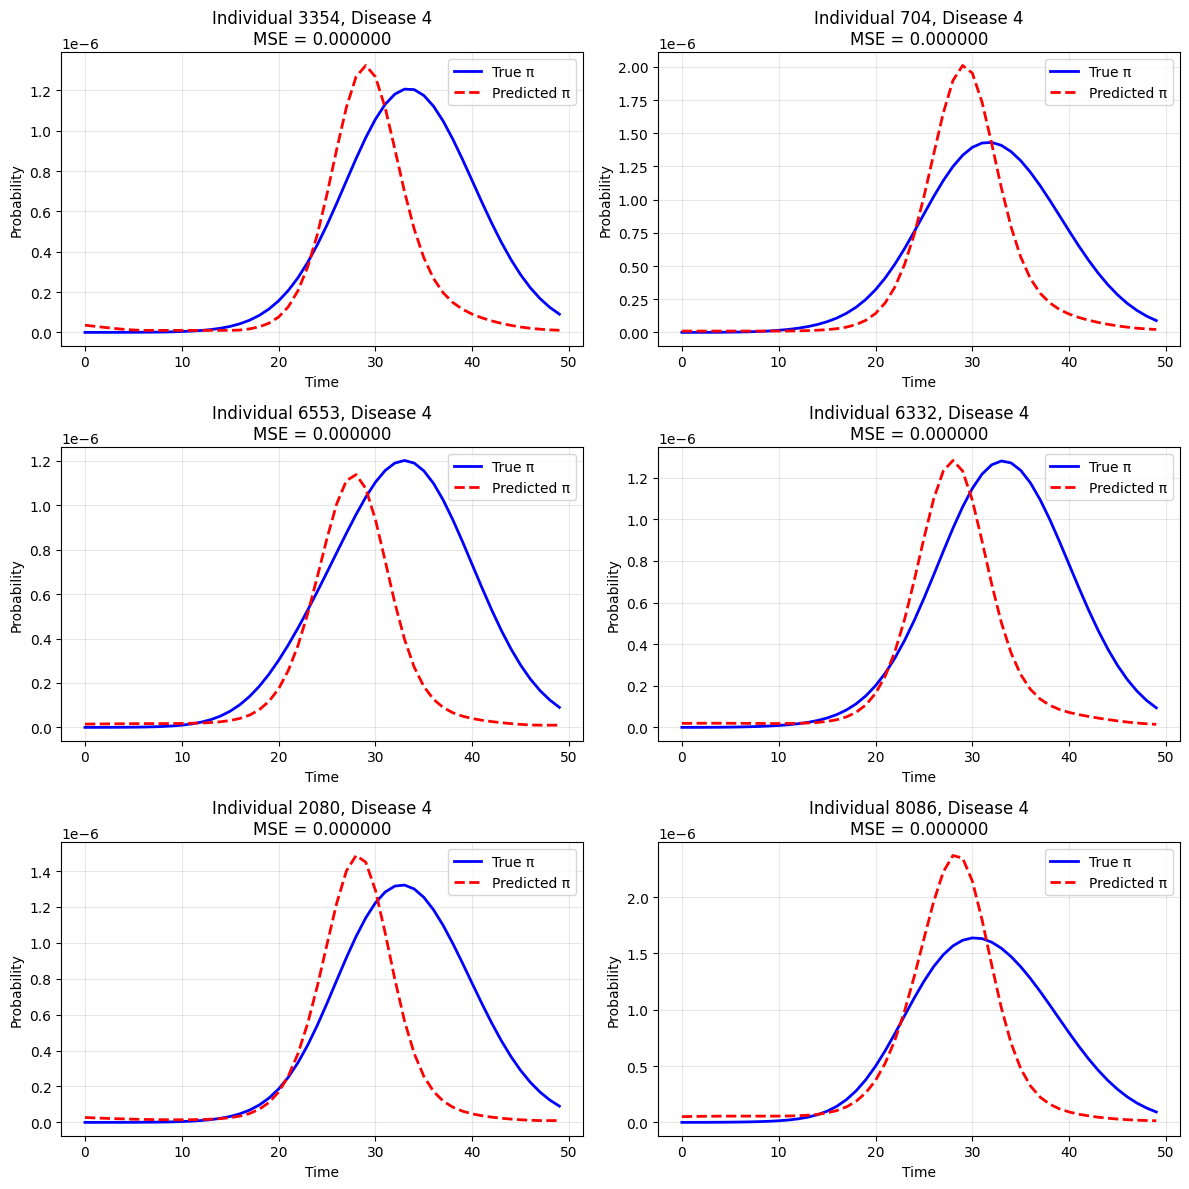

In [276]:
plot_best_matches(data['pi'], model_est.forward()[0],n_samples=6)



Top 10 largest discrepancies between predicted and observed risks:
    predicted_risk  observed_risk  ratio_pred_obs  n_events  n_at_risk
7         0.097953       0.627039        0.156216      5190       8277
10        0.057590       0.164323        0.350466      1636       9956
16        0.008129       0.072438        0.112225       723       9981
15        0.000842       0.007201        0.116959        72       9998
13        0.001173       0.007111        0.164966        71       9985
2         0.000980       0.004000        0.244921        40       9999
17        0.000919       0.002500        0.367689        25      10000
14        0.000030       0.000900        0.032981         9      10000
8         0.000008       0.000500        0.015259         5      10000
1         0.000003       0.000400        0.006557         4      10000

Summary statistics of prediction/observation ratios:
count    14.000000
mean      0.119915
std       0.125224
min       0.005960
25%       0.010520
50

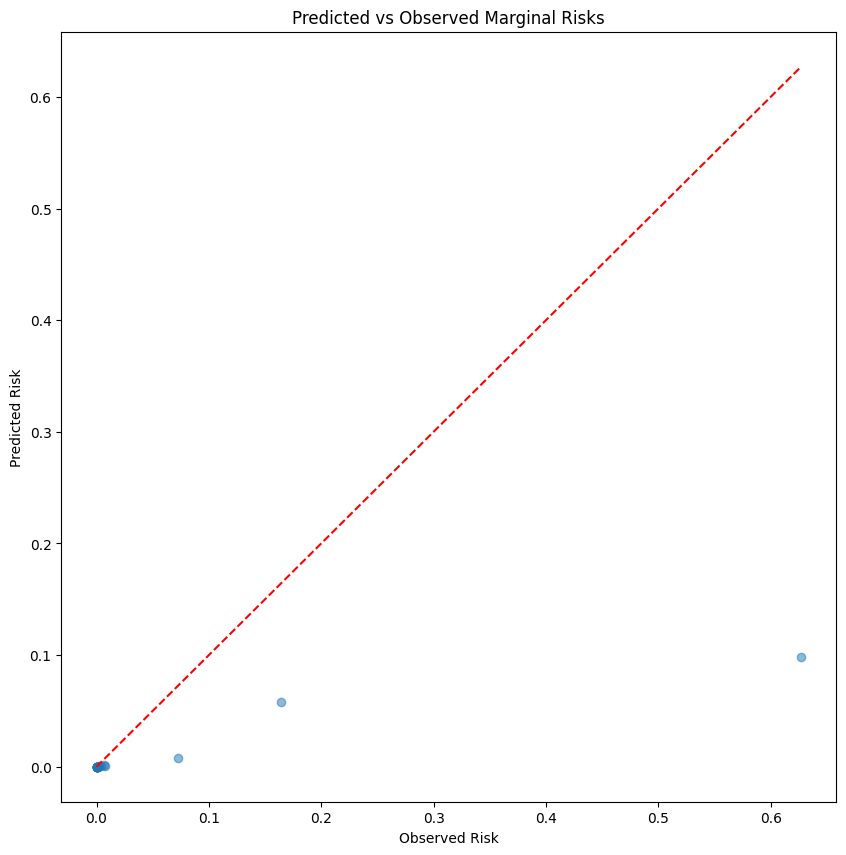

In [295]:
def verify_marginal_probabilities(Y, pi_pred, age_start=10, age_window=10):
    """
    Compare predicted marginal probabilities with observed rates
    """
    N, D, T = Y.shape
    verification = []
    
    for d in range(D):
        # Get people at risk
        at_risk = ~np.any(Y[:, d, :age_start], axis=1)
        n_at_risk = np.sum(at_risk)
        
        if n_at_risk >= 100:  # Minimum sample size
            # Predicted probability
            yearly_pi = pi_pred[at_risk, d, age_start:age_start+age_window]
            pred_risk = 1 - np.prod(1 - yearly_pi, axis=1).mean()
            
            # Observed probability
            observed = np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1).mean()
            
            verification.append({
                #'disease': disease_name_list[d],
                'predicted_risk': pred_risk,
                'observed_risk': observed,
                'ratio_pred_obs': pred_risk/observed if observed > 0 else np.nan,
                'n_at_risk': n_at_risk,
                'n_events': np.sum(np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1))
            })
    
    verify_df = pd.DataFrame(verification)
    
    # Sort by absolute difference between predicted and observed
    verify_df['abs_diff'] = np.abs(verify_df.predicted_risk - verify_df.observed_risk)
    verify_df = verify_df.sort_values('abs_diff', ascending=False)
    
    print("\nTop 10 largest discrepancies between predicted and observed risks:")
    print(verify_df.head(10)[['predicted_risk', 'observed_risk', 'ratio_pred_obs', 'n_events', 'n_at_risk']])
    
    print("\nSummary statistics of prediction/observation ratios:")
    print(verify_df.ratio_pred_obs.describe())
    
    # Plot predicted vs observed
    plt.figure(figsize=(10, 10))
    plt.scatter(verify_df.observed_risk, verify_df.predicted_risk, alpha=0.5)
    plt.plot([0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             [0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             'r--')
    plt.xlabel('Observed Risk')
    plt.ylabel('Predicted Risk')
    plt.title('Predicted vs Observed Marginal Risks')
    plt.show()
    
    return verify_df
data['Y'].shape
with torch.no_grad():  
    pi_pred =model_est.forward()[0].cpu().numpy()
# Run verification
verify_df = verify_marginal_probabilities(Y=data['Y'],pi_pred=pi_pred)

In [297]:
model.psi

Parameter containing:
tensor([[ 1.0406,  0.9608,  0.9595,  0.9605, -2.9613, -3.0083, -2.9598, -2.9622,
         -2.9598, -2.9596, -3.0337, -2.9622, -3.0370, -3.0344, -2.9635, -3.0433,
         -2.9614, -2.9582, -2.9593, -3.0270],
        [-3.0394, -2.9629, -3.0348, -2.9607,  1.0368,  0.9624,  0.9591,  1.0374,
         -2.9639, -2.9584, -2.9593, -2.9575, -3.0382, -3.0350, -2.9568, -2.9633,
         -2.9608, -3.0398, -3.0395, -3.0365],
        [-2.9794, -3.0411, -3.0286, -3.0141, -3.0259, -2.9592, -2.9591, -3.0373,
          1.0396,  1.0397,  1.0400,  1.0381, -3.0430, -3.0334, -3.0395, -3.0412,
         -3.0426, -3.0307, -3.0395, -2.9590],
        [-3.0395, -3.0393, -3.0418, -2.9635, -3.0389, -3.0425, -2.9619, -3.0359,
         -3.0298, -3.0408, -2.9779, -2.9586,  1.0390,  1.0416,  1.0404,  1.0288,
         -3.0374, -2.9593, -3.0043, -3.0398],
        [-2.9699, -2.9592, -3.0268, -3.0436, -3.0117, -2.9630, -2.9579, -3.0397,
         -3.0425, -2.9595, -3.0415, -2.9596, -3.0397, -2.9626, -2

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)


Lambda kernel condition number: 45214952.00
Phi kernel condition number: 104912536.00

Cluster Sizes:
Cluster 0: 3 diseases
Cluster 1: 8 diseases
Cluster 2: 4 diseases
Cluster 3: 3 diseases
Cluster 4: 2 diseases
Initialization complete!


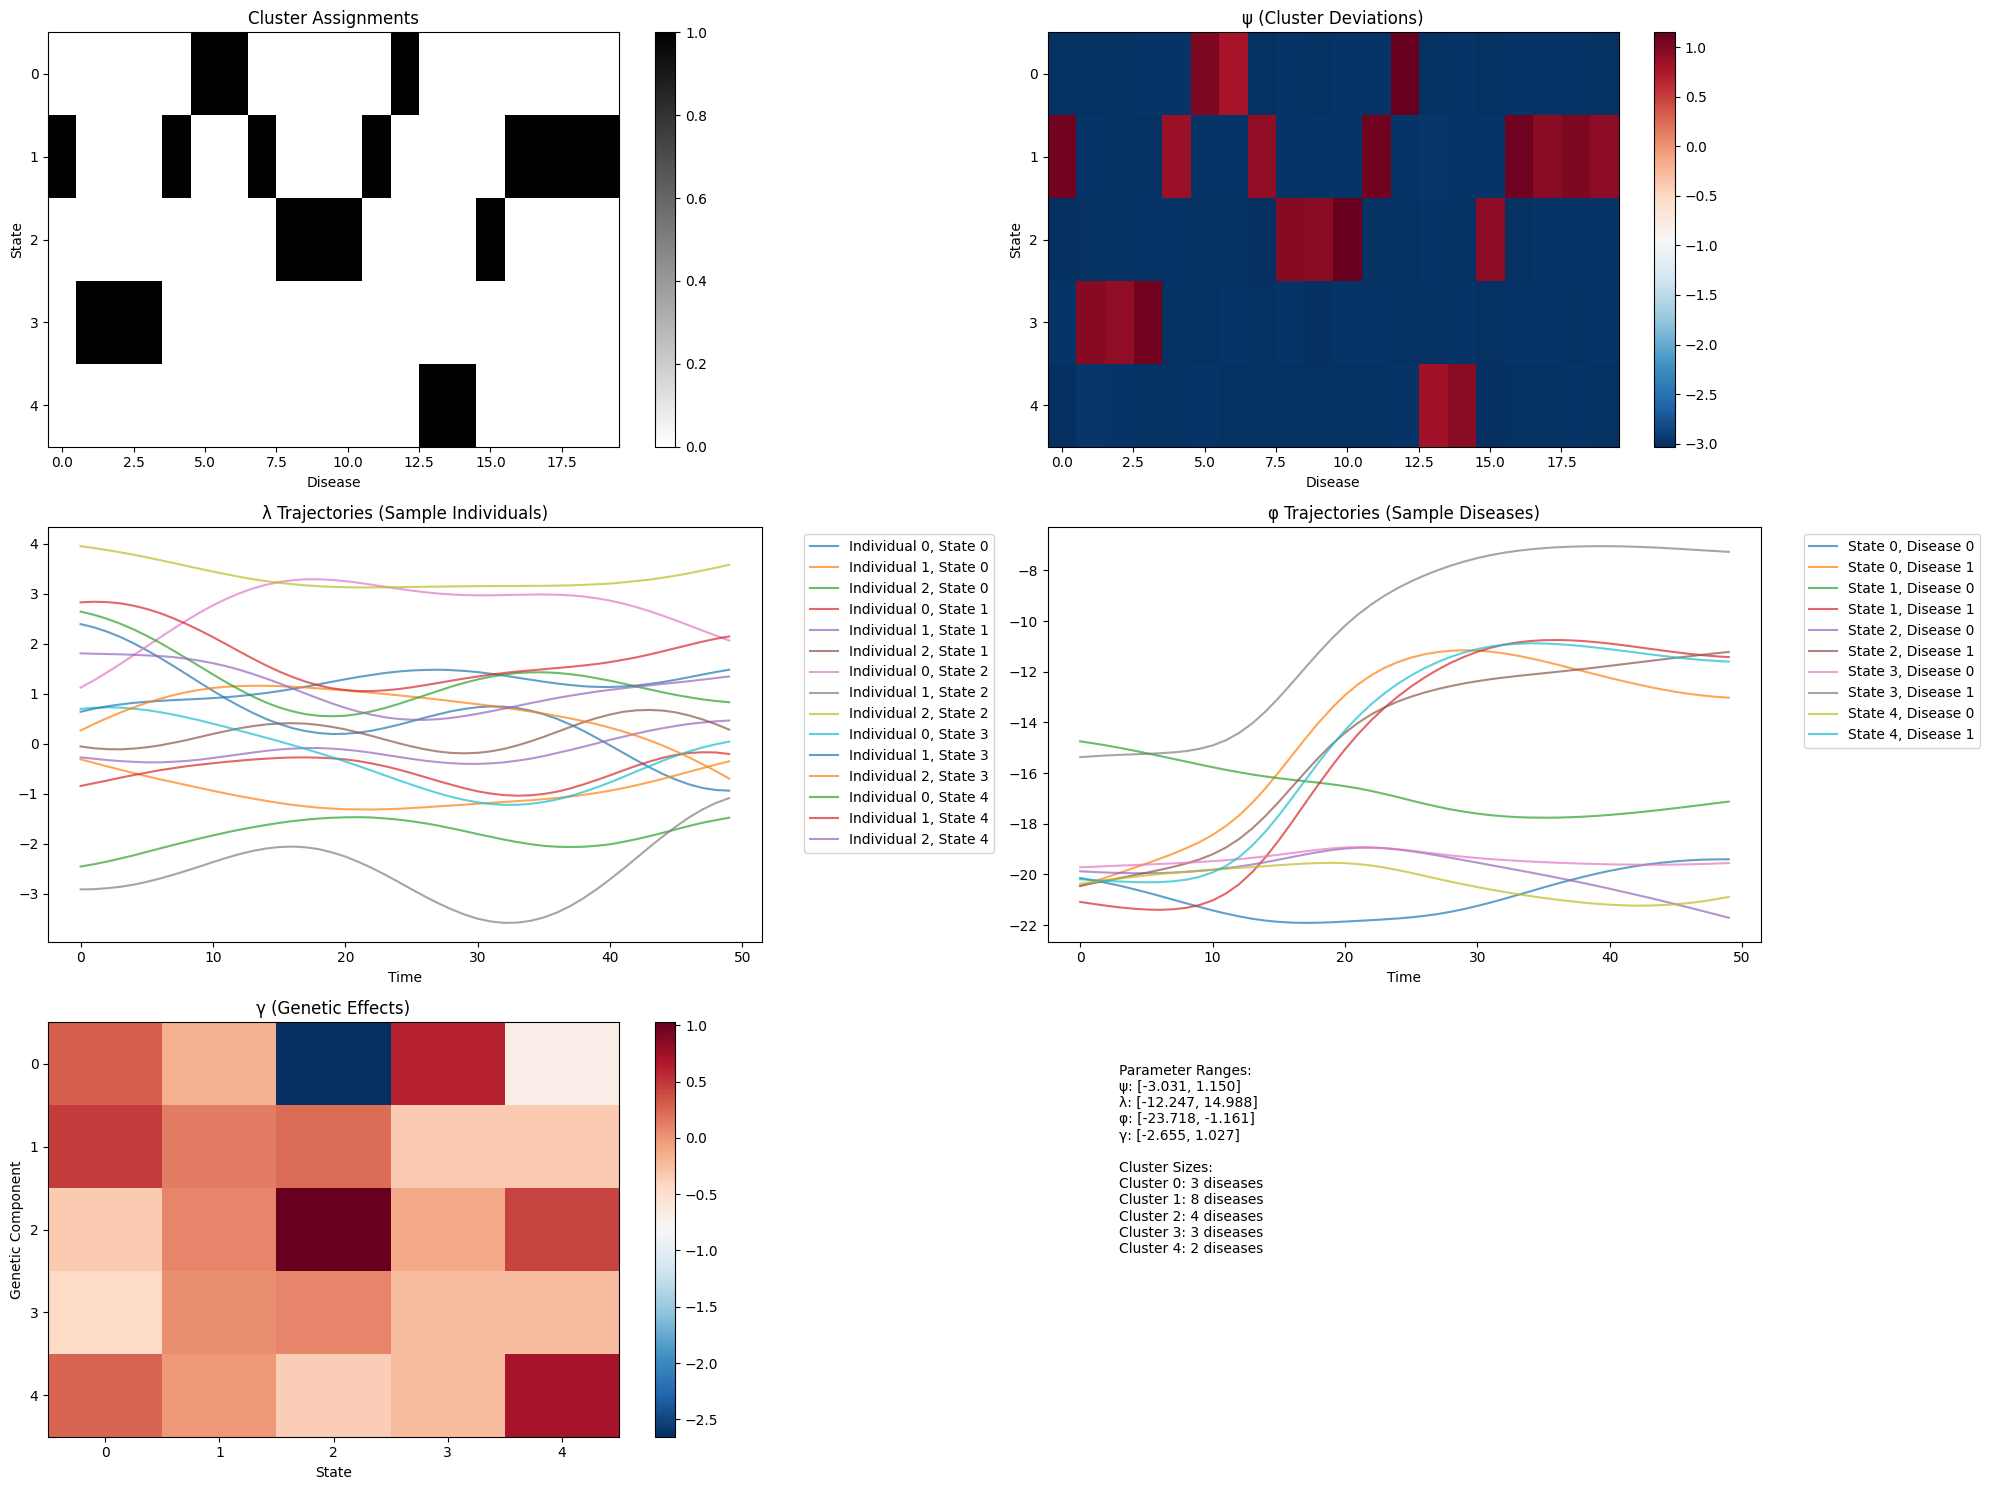

In [303]:
from cluster_g_logit_init import *
# Calculate prevalence_t from synthetic data
prevalence_t = compute_smoothed_prevalence(Y_tensor)  # Average over individuals

# Initialize model with synthetic data
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit(
    N=data['Y'].shape[0], 
    D=data['Y'].shape[1], 
    T=data['Y'].shape[2], 
    K=data['phi'].shape[0],  # number of clusters
    P=data['G'].shape[1],    # number of genetic features
    G=G_tensor,
    Y=Y_tensor,              # Added Y_tensor
    prevalence_t=prevalence_t
)

# Initialize with true psi
#model.initialize_params(true_psi=true_psi)


model.visualize_initialization()


In [304]:
history = model.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)


Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init.py:283: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 291.5403
Psi gradient stats:
Mean: 2.1004e-02
Std:  9.3000e-02
Max:  2.1807e-01
Min:  -2.9862e-01
Average psi change: 9.9921e-05
Epoch 0, Loss: 291.5403, Gradients - Lambda: 4.867e-01, Phi: 1.935e+02, Gamma: 3.673e-02, Psi: 2.986e-01

Epoch 1
Loss: 227.9882
Psi gradient stats:
Mean: 2.0937e-02
Std:  9.2640e-02
Max:  2.1772e-01
Min:  -3.0001e-01
Average psi change: 9.9856e-05
Epoch 1, Loss: 227.9882, Gradients - Lambda: 4.616e-01, Phi: 1.837e+02, Gamma: 3.534e-02, Psi: 3.000e-01

Estimated total training time: 395.6 minutes

Epoch 2
Loss: 182.6343
Psi gradient stats:
Mean: 2.0925e-02
Std:  9.2271e-02
Max:  2.1730e-01
Min:  -3.0001e-01
Average psi change: 9.9611e-05
Epoch 2, Loss: 182.6343, Gradients - Lambda: 4.358e-01, Phi: 1.741e+02, Gamma: 3.409e-02, Psi: 3.000e-01

Epoch 3
Loss: 151.6663
Psi gradient stats:
Mean: 2.0945e-02
Std:  9.1903e-02
Max:  2.1656e-01
Min:  -2.9996e-01
Average psi change: 9.9111e-05
Epoch 3, Loss: 151.6663, Gradients - Lambda: 4.093e-01, Phi: 1.

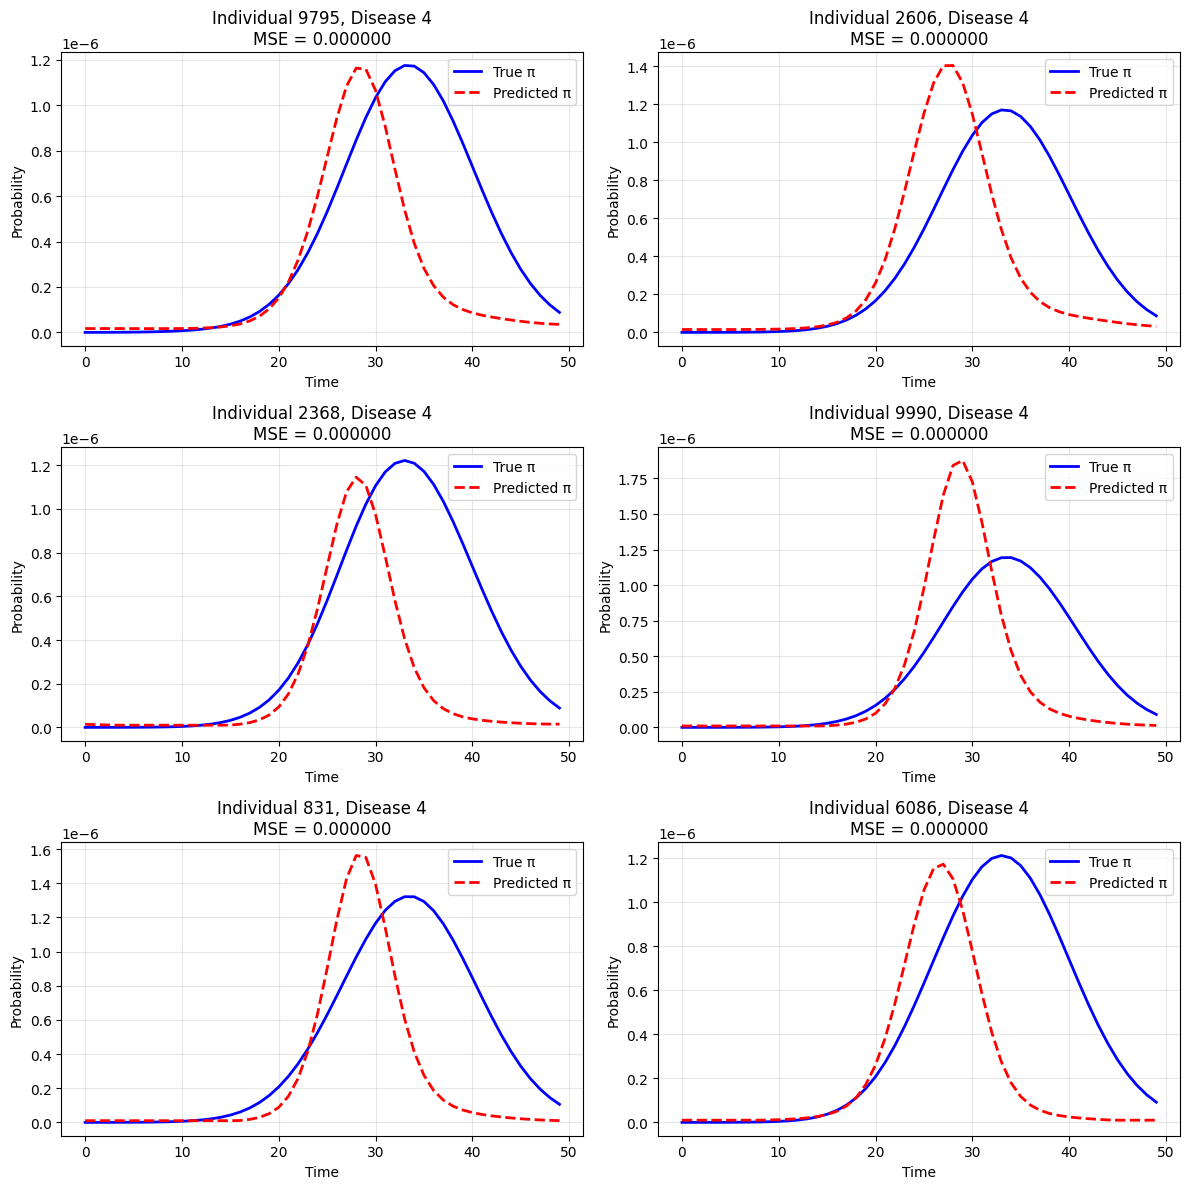

In [305]:
plot_best_matches(data['pi'], model.forward()[0],n_samples=6)



Top 10 largest discrepancies between predicted and observed risks:
    predicted_risk  observed_risk  ratio_pred_obs  n_events  n_at_risk
7         0.140466       0.627039        0.224014      5190       8277
10        0.025425       0.164323        0.154726      1636       9956
16        0.042994       0.072438        0.593532       723       9981
15        0.000886       0.007201        0.123051        72       9998
2         0.000405       0.004000        0.101124        40       9999
13        0.010459       0.007111        1.470856        71       9985
17        0.000772       0.002500        0.308681        25      10000
14        0.000040       0.000900        0.044041         9      10000
8         0.000027       0.000500        0.054240         5      10000
9         0.000005       0.000400        0.012219         4      10000

Summary statistics of prediction/observation ratios:
count    14.000000
mean      0.225838
std       0.392567
min       0.001192
25%       0.029244
50

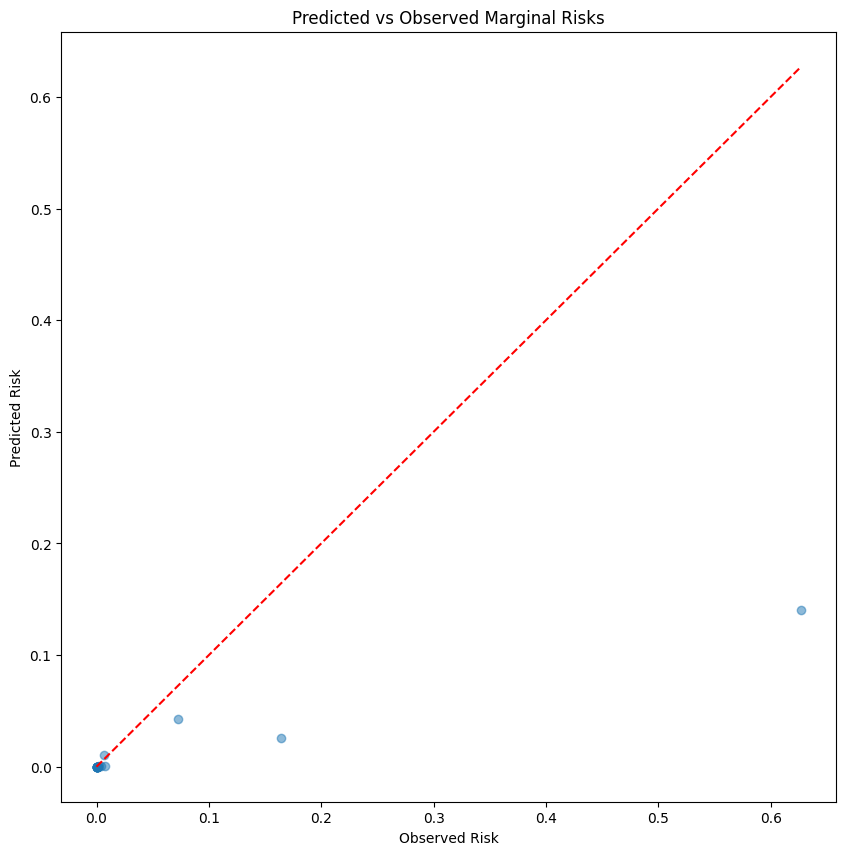

In [306]:
def verify_marginal_probabilities(Y, pi_pred, age_start=10, age_window=10):
    """
    Compare predicted marginal probabilities with observed rates
    """
    N, D, T = Y.shape
    verification = []
    
    for d in range(D):
        # Get people at risk
        at_risk = ~np.any(Y[:, d, :age_start], axis=1)
        n_at_risk = np.sum(at_risk)
        
        if n_at_risk >= 100:  # Minimum sample size
            # Predicted probability
            yearly_pi = pi_pred[at_risk, d, age_start:age_start+age_window]
            pred_risk = 1 - np.prod(1 - yearly_pi, axis=1).mean()
            
            # Observed probability
            observed = np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1).mean()
            
            verification.append({
                #'disease': disease_name_list[d],
                'predicted_risk': pred_risk,
                'observed_risk': observed,
                'ratio_pred_obs': pred_risk/observed if observed > 0 else np.nan,
                'n_at_risk': n_at_risk,
                'n_events': np.sum(np.any(Y[at_risk, d, age_start:age_start+age_window], axis=1))
            })
    
    verify_df = pd.DataFrame(verification)
    
    # Sort by absolute difference between predicted and observed
    verify_df['abs_diff'] = np.abs(verify_df.predicted_risk - verify_df.observed_risk)
    verify_df = verify_df.sort_values('abs_diff', ascending=False)
    
    print("\nTop 10 largest discrepancies between predicted and observed risks:")
    print(verify_df.head(10)[['predicted_risk', 'observed_risk', 'ratio_pred_obs', 'n_events', 'n_at_risk']])
    
    print("\nSummary statistics of prediction/observation ratios:")
    print(verify_df.ratio_pred_obs.describe())
    
    # Plot predicted vs observed
    plt.figure(figsize=(10, 10))
    plt.scatter(verify_df.observed_risk, verify_df.predicted_risk, alpha=0.5)
    plt.plot([0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             [0, max(verify_df.observed_risk.max(), verify_df.predicted_risk.max())], 
             'r--')
    plt.xlabel('Observed Risk')
    plt.ylabel('Predicted Risk')
    plt.title('Predicted vs Observed Marginal Risks')
    plt.show()
    
    return verify_df
data['Y'].shape
with torch.no_grad():  
    pi_pred =model.forward()[0].cpu().numpy()
# Run verification
verify_df = verify_marginal_probabilities(Y=data['Y'],pi_pred=pi_pred)

In [308]:
model.lambda_

Parameter containing:
tensor([[[ 2.3960,  2.3283,  2.2400,  ..., -0.8835, -0.9286, -0.9477],
         [-0.8531, -0.7937, -0.7355,  ..., -0.1721, -0.1772, -0.2035],
         [ 1.1227,  1.2680,  1.4255,  ...,  2.2607,  2.1604,  2.0649],
         [ 0.6984,  0.7193,  0.7262,  ..., -0.0773, -0.0117,  0.0405],
         [ 2.6412,  2.5785,  2.4982,  ...,  0.8859,  0.8524,  0.8273]],

        [[-0.3149, -0.3857, -0.4549,  ..., -0.4895, -0.4195, -0.3524],
         [-0.2688, -0.3005, -0.3285,  ...,  0.4233,  0.4468,  0.4632],
         [-2.9171, -2.9109, -2.8936,  ..., -1.3157, -1.1843, -1.0833],
         [ 0.6433,  0.6969,  0.7426,  ...,  1.3817,  1.4358,  1.4878],
         [ 2.8252,  2.8384,  2.8326,  ...,  2.0400,  2.0984,  2.1497]],

        [[-2.4628, -2.4141, -2.3589,  ..., -1.5852, -1.5284, -1.4801],
         [-0.0681, -0.0965, -0.1114,  ...,  0.4842,  0.3878,  0.2783],
         [ 3.9457,  3.9132,  3.8745,  ...,  3.4637,  3.5192,  3.5776],
         [ 0.2650,  0.3884,  0.5071,  ..., -0.4119,

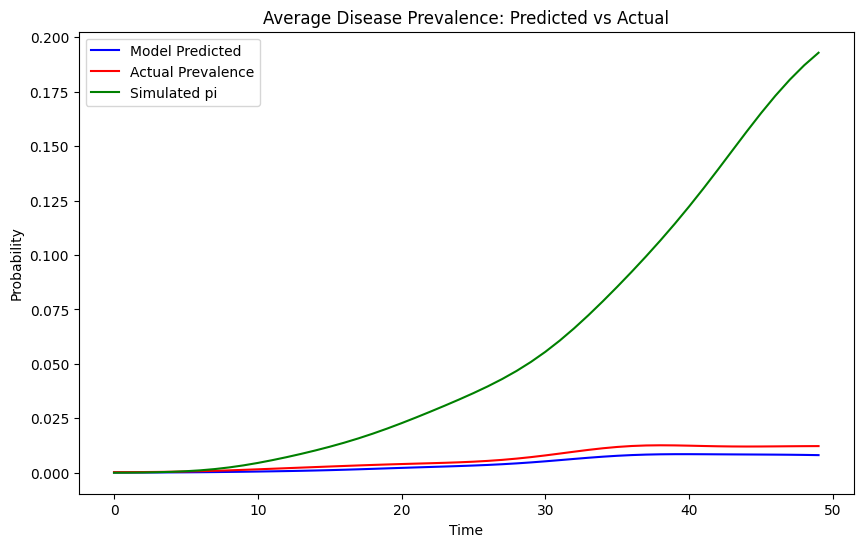

In [307]:
# Average over all diseases and all individuals
mean_pred_all = pi_pred.mean(axis=(0,1))  # Average across people and diseases
real_incidence_all = model.prevalence_t.mean(axis=0)  # Average across diseases
real_pi_all = data['pi'].mean(axis=(0,1)) # Average across diseases

plt.figure(figsize=(10,6))
plt.plot(mean_pred_all, 'b-', label='Model Predicted')
plt.plot(real_incidence_all, 'r-', label='Actual Prevalence') 
plt.plot(real_pi_all, 'g-', label='Simulated pi') 


plt.title('Average Disease Prevalence: Predicted vs Actual')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()